In [1]:
import os

import pandas as pd

import numpy as np

import matplotlib.pyplot as plt

import glob

from pathlib import Path

import scipy.stats as stats

from scipy import stats

In [2]:
def t2_mean(path):
    
    # input the directory to the set of files as a raw string e.g. r'C:\projects\CONUS_TGW_WRF_SSP585_HOT\CONUS_TGW_WRF_SSP585_HOT'
    files_path = path
    list_of_files = glob.glob(os.path.join(files_path , "*.csv"))
    
    # create a list of the mean of T2 of each file
    means_list = []
    for file_name in list_of_files:
        df = pd.read_csv(file_name, index_col = None, header = 0)
        means_list.append(df['T2'].mean())
    
    means_df = pd.DataFrame(means_list, columns = ["T2_Mean"])
    
    # create list of file names to get more information for each T2
    files = []
    for file_path in list_of_files:
        name = os.path.basename(file_path)
        files.append(name)
     
    # split the file names into lists in BA_list
    BA_list_split = []
    for csv_name in range(len(files)):
        base_name = os.path.splitext(os.path.basename(files[csv_name]))[0]
        split = base_name.split("_")
        BA_list_split.append(split)
        
    # take the first elements (BAs) and last elements (years) and put them into their respective lists
    BA_names = []
    years = []
    for file_list in BA_list_split:
        BA_names.append(file_list[0])
        years.append(file_list[5])
        
    # add BA and Year columns to dataframe and correct the column order
    means_df['BA'] = BA_names
    means_df['Year'] = years

    means_df = means_df[['BA', 'Year', 'T2_Mean']]
    
    return means_df

In [3]:
# create a df for both the cold and hot datasets using t2_mean function
hot_df = t2_mean(r'C:\projects\CONUS_TGW_WRF_SSP585_HOT\CONUS_TGW_WRF_SSP585_HOT')
cold_df = t2_mean(r'C:\projects\CONUS_TGW_WRF_SSP585_COLD\CONUS_TGW_WRF_SSP585_COLD')

In [4]:
def t2_visual(input_BA): # insert a BA as a string e.g. 'AEC'
    
    # need to take the BA string input, and create subsets of hot_df and cold_df from them
    cold_BA = cold_df.loc[(cold_df['BA'] == input_BA)]
    hot_BA = hot_df.loc[(hot_df['BA'] == input_BA)]
    
    # create and show the visualization
    plt.plot(hot_BA['Year'], hot_BA['T2_Mean'], color = "red", label = "Hot")
    plt.plot(cold_BA['Year'], cold_BA['T2_Mean'], color = "blue", label = "Cold")
    
    plt.legend(loc="upper left")
    plt.xlabel('Year')
    plt.title('A Comparison of ' + input_BA + ' Scenarios')
    plt.ylabel('T2_Mean (K)')

    plt.xticks([0, 20, 40, 60, 79])
    
    plt.show()
    
    # express the temperature differences at initial and final points
    temp_diff_df = hot_BA['T2_Mean'] - cold_BA['T2_Mean']
    
    temp_diff_li = list(temp_diff_df)

    # use for loop to print where difference becomes "significant" e.g. 1 dg
    initial_temp_diff = temp_diff_df.iloc[0].round(2)
    final_temp_diff = temp_diff_df.iloc[-1].round(2)
    
    print('2020 temperature difference: ' + str(initial_temp_diff))
    print('2099 temperature difference: ' + str(final_temp_diff))
    
    # add units (kelvin) maybe convert to F
    
    return

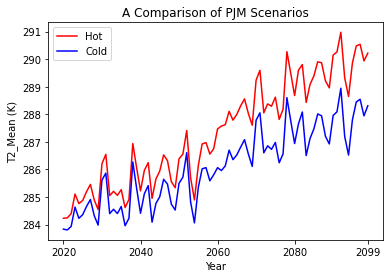

2020 temperature difference: 0.4
2099 temperature difference: 1.91


In [5]:
t2_visual('PJM')

In [6]:
def temp_diff_years(input_temp): # input temp as float/integer.
      
    # get list of unique BAs
    BA_unique = hot_df.BA.unique()
    BA_list = list(BA_unique)
    
    # subset hot/cold data for each BA
    temp_gap_years = []
    for BA_name in BA_list:
        cold_BA = cold_df.loc[(cold_df['BA'] == BA_name)]
        hot_BA = hot_df.loc[(hot_df['BA'] == BA_name)]
        
        # within subset, find temp difference > input temp
        temp_diff_df = hot_BA['T2_Mean'] - cold_BA['T2_Mean']
        temp_diff_li = list(temp_diff_df)
        year_li = list(range(2020, 2099))
    
        for temp_diff in temp_diff_li:
            if temp_diff > input_temp:
                temp_index = temp_diff_li.index(temp_diff)
                break
                
        # take that temp_index, and append to list of temp_gap_years, which is the year the difference between hot and cold first exceeded input_temp
        first_year = year_li[temp_index]
        temp_gap_years.append(first_year)
        
    # sort temp_gap_years in order
    temp_gap_years.sort()

    return temp_gap_years

In [7]:
def temp_divergence_graph(input_deg): # input a float of the degrees K that you would like to see a graph for
    
    # get list of years where the temperature first diverges by the input_deg, using temp_diff_years function
    deg_difference = temp_diff_years(input_deg)
    
    # sort years by ascending order
    deg_difference.sort()
    
    # create dictionary to count number of times each year appears in one_dg
    deg_difference_dict = {i:deg_difference.count(i) for i in deg_difference}
    
    # plot a bar graph
    years = list(deg_difference_dict.keys())
    difference_counts = list(deg_difference_dict.values())
    
    plt.bar(years, difference_counts, color = 'pink')
    plt.xlabel('Year')
    plt.ylabel(str(input_deg) + ' dg K Differences per BA')
    plt.title('Years where Hot and Cold first diverge by ' + str(input_deg) + ' dg K')
    
    return

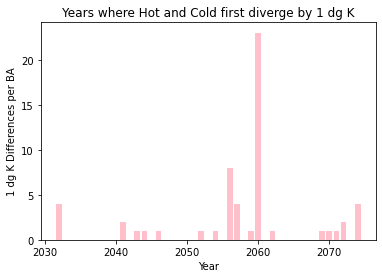

In [8]:
temp_divergence_graph(1)

Connect BAs to their 1dg difference showing up in a dataframe. so then we can see if location is related.

In [9]:
def data_chunk(first_year, files_path, input_BA): # input first_year as an integer: the first year of the decade you want e.g. 2020. input file_path as a raw string directory
                                                       # e.g. r'C:\projects\CONUS_TGW_WRF_SSP585_HOT\CONUS_TGW_WRF_SSP585_HOT' . input input_BA as a string e.g. 'AEC'
    # get a list of the files from the path
    list_of_files = glob.glob(os.path.join(files_path, f'{input_BA}_*.csv'))
    
    # get a list of the elements of each file name
    BA_list_split = []
    for file_index in range(len(list_of_files)):
        base_name = os.path.splitext(os.path.basename(list_of_files[file_index]))[0]
        split = base_name.split("_")
        BA_list_split.append(split)

    # get a list of the BA names, with the same indexes as their original file names
    BA_names = []
    for file_list in BA_list_split:
        BA_names.append(file_list[0])
        
    # get the first file with which to start pulling hourly data
    for file_index in range(len(list_of_files)):
        if input_BA == BA_names[file_index]:
            if str(first_year) in list_of_files[file_index]:
                first_file = list_of_files[file_index]
                break
                
    # get a list of the 10 files to unpack
    index_first_file = list_of_files.index(first_file)
    decade_file_list = []
    for file in list_of_files[index_first_file:]:
        if len(decade_file_list) == 10:
            break
        decade_file_list.append(file)
        
    # create aggregate df of all t2 values from each file_name df
    t2_bins = np.arange(250,325,2)
    for file_name in range(len(decade_file_list)):
        
        # read in the file as a df
        df = pd.read_csv(decade_file_list[file_name], index_col = None, header = 0)
        
        # aggregate output into a new dataframe:
        if file_name == 0:
            aggregate_output_df = df
        else:
            aggregate_output_df = pd.concat([aggregate_output_df, df], axis = 0)
    
    # create histogram of t2 values
    hist, bin_edges = np.histogram(aggregate_output_df['T2'], bins = t2_bins, density = True)
    hist_df = pd.DataFrame(hist, columns = [str(file_name)])
    
    
    # the line below checks for the pdf integral sum to 1
    # print(np.sum(hist * np.diff(bin_edges)))
     
    return hist_df

In [10]:
def BA_decade_plot(input_BA, files_path): # input input_BA as a string e.g. 'AEC' 
                                          # input files_path as raw string e.g. r'C:\projects\CONUS_TGW_WRF_SSP585_HOT\CONUS_TGW_WRF_SSP585_HOT'
    # create list of decades to loop through
    decades = [2020, 2030, 2040, 2050, 2060, 2070, 2080, 2090]
    
    plt.figure(figsize=(25, 10))
    list_colors = ['blue', 'cornflowerblue', 'skyblue', 'orchid', 'lightcoral', 'indianred', 'tomato',  'red']
    
    t2_bins = np.arange(250,325,2)
    
    # loop through decades, creating a data_chunk of each decade for the input_BA
    for decade in range(len(decades)):
        data_decade = data_chunk(decades[decade], files_path, input_BA)
        
        # plot on line graph
        plt.plot(t2_bins[0:(t2_bins.size - 1)], data_decade, label = str(decades[decade]), color = list_colors[decade])
    
    # add information to plot
    plt.legend(loc = "upper right")
    plt.xlabel('T2 (K)')
    plt.title('Frequency of T2 Occurrences for ' + input_BA)
    plt.ylabel('Frequency')
    
    return

In [11]:
def BA_decade_plot_comparison(input_BA): # enter input_BA as a string e.g. 'AEC'
    
    # plot both hot and cold BA_decade_plot to better compare
    BA_decade_plot(input_BA, r'C:\projects\CONUS_TGW_WRF_SSP585_COLD\CONUS_TGW_WRF_SSP585_COLD')
    BA_decade_plot(input_BA, r'C:\projects\CONUS_TGW_WRF_SSP585_HOT\CONUS_TGW_WRF_SSP585_HOT')
    
    return

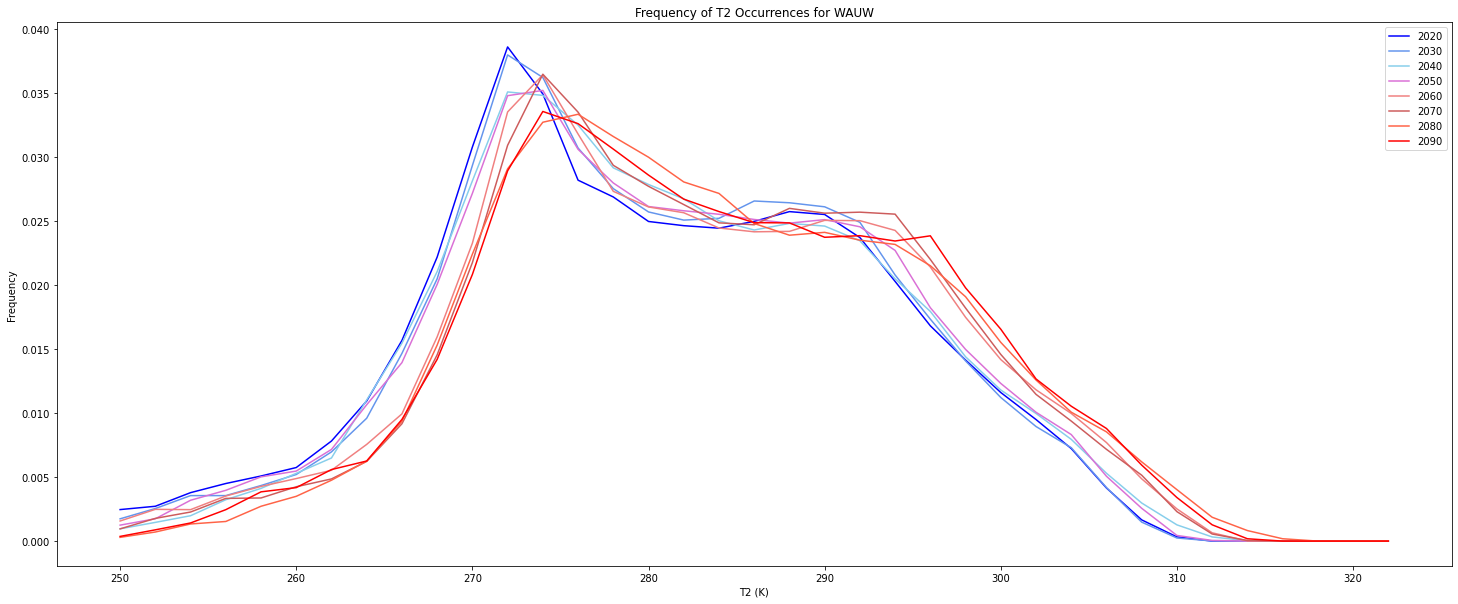

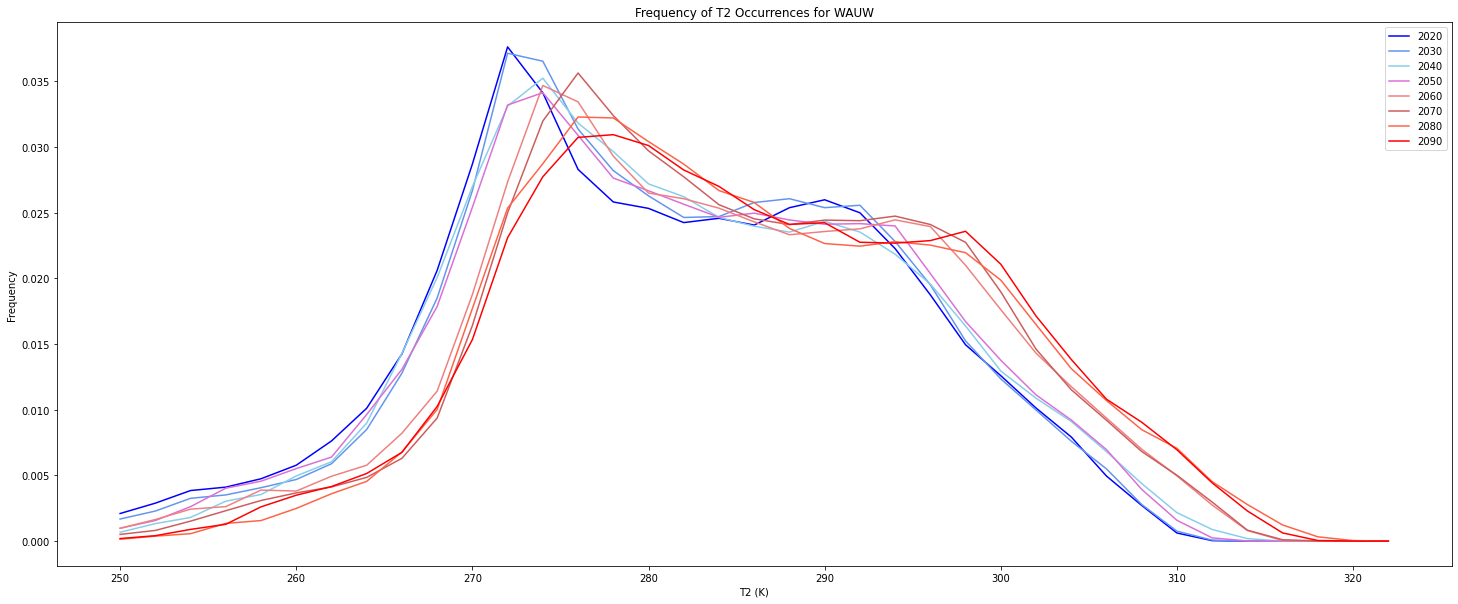

In [12]:
BA_decade_plot_comparison('WAUW')

In [13]:
def BA_array(files_path, input_BA): # input file_path as a raw string directory e.g. r'C:\projects\CONUS_TGW_WRF_SSP585_HOT\CONUS_TGW_WRF_SSP585_HOT' 
                                    # input input_BA as a string e.g. 'AEC'
    # get a list of the files from the path
    list_of_files = glob.glob(os.path.join(files_path, f'{input_BA}_*.csv'))
    
    # read in each csv file as a df
    for file_index in range(len(list_of_files)):
        df = pd.read_csv(list_of_files[file_index], index_col = None, header = 0)
        
        if file_index == 0:
            big_array = df['T2'].to_numpy()
            
        else:
            file_array = df['T2'].to_numpy()
            big_array = np.concatenate((big_array, file_array))
            
    return big_array

In [14]:
# make two arrays of full t2 data for t-test
hot_array_AEC = BA_array(r'C:\projects\CONUS_TGW_WRF_SSP585_HOT\CONUS_TGW_WRF_SSP585_HOT', 'AEC')
cold_array_AEC = BA_array(r'C:\projects\CONUS_TGW_WRF_SSP585_COLD\CONUS_TGW_WRF_SSP585_COLD', 'AEC')

# check ratio of the var of both arrays to make sure can say equal var
print(np.var(hot_array_AEC), np.var(cold_array_AEC))

# run t-test
stats.ttest_ind(a = hot_array_AEC, b = cold_array_AEC, equal_var = True)

84.42607557274209 80.6259699995428


Ttest_indResult(statistic=69.51316215605367, pvalue=0.0)

Looking at annual data (for a given year), reading in time-series for hot run and cold run for a particular BA. What test should we use, to see if those distributions are similar or not? Our hourly data is not independent, as each hourly measurement is dependent on the previous. So how do we get independent samples? Think of shrinking the values to get independent. Try looping over each year, run t-test for each one. Output a time-series of the p-values to see where it becomes significant. Then we do for each of the BAs.

What if we want to test if some extreme value is different between the hot and cold values? T-test tests the mean, but need to see if the extremes are also statistically significant. Because remember power plants are looking to support peak electricity load, so need stuff on 95th percentile of data (like take the top 5% of temp values, and maybe perform t-test on that). Thoughts on assumption of normality? They seem fairly normal, but might be worth to check.

In [27]:
# make two arrays of a single year of t2 data for comparison
aec_2020_cold_df = pd.read_csv('C:\projects\CONUS_TGW_WRF_SSP585_COLD\CONUS_TGW_WRF_SSP585_COLD\AEC_WRF_Hourly_Mean_Meteorology_2090.csv', index_col = None, header = 0)
aec_2020_cold_t2_array = aec_2020_cold_df['T2'].to_numpy()

aec_2020_hot_df = pd.read_csv('C:\projects\CONUS_TGW_WRF_SSP585_HOT\CONUS_TGW_WRF_SSP585_HOT\AEC_WRF_Hourly_Mean_Meteorology_2090.csv', index_col = None, header = 0)
aec_2020_hot_t2_array = aec_2020_hot_df['T2'].to_numpy()

# get 95th percentile of both arrays
cold_95_percentile = np.percentile(aec_2020_cold_t2_array, 95)
hot_95_percentile = np.percentile(aec_2020_hot_t2_array, 95)

# create arrays of the top 5% of temps for hot and cold
cold_95_percentile_list = []
for temp in aec_2020_cold_t2_array:
    if temp >= cold_95_percentile:
        cold_95_percentile_list.append(temp)
        
cold_95_min = min(cold_95_percentile_list)
cold_95_max = max(cold_95_percentile_list)

cold_95_df = pd.DataFrame(cold_95_percentile_list, columns = ['T2'])

# cold_95_percentile_array = np.asarray(cold_95_percentile_list)

hot_95_percentile_list = []
for temp in aec_2020_hot_t2_array:
    if temp >= hot_95_percentile:
        hot_95_percentile_list.append(temp)
        
hot_95_df = pd.DataFrame(hot_95_percentile_list, columns = ['T2'])

# hot_95_percentile_array = np.asarray(hot_95_percentile_list)

hot_95_min = min(hot_95_percentile_list)
hot_95_max = max(hot_95_percentile_list)

439


In [19]:
hot_t2_bins = np.arange(hot_95_min, hot_95_max, 0.2)
hot_hist, bin_edges = np.histogram(hot_95_df['T2'], bins = hot_t2_bins, density = True)
# hot_hist_df = pd.DataFrame(hot_hist, columns = ['T2'])

cold_t2_bins = np.arange(cold_95_min, cold_95_max, 0.2)
cold_hist, bin_edges_2 = np.histogram(cold_95_df['T2'], bins = hot_t2_bins, density = True)
# hot_hist_df = pd.DataFrame(hot_hist, columns = ['T2'])

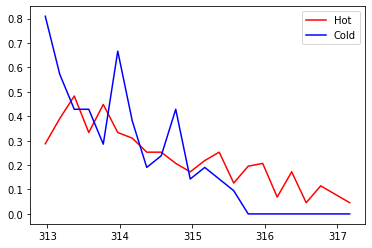

In [23]:
plt.plot(hot_t2_bins[0:(hot_t2_bins.size - 1)], hot_hist, color = "red", label = "Hot")
plt.plot(hot_t2_bins[0:(hot_t2_bins.size - 1)], cold_hist, color = "blue", label = "Cold")
plt.legend(loc="upper right")

Okay I think what I want to do is create a function that goes through the approx. 400 datapoints in the top 5% of a given year (for both hot and cold) and t-tests them to see if the means are significantly different from each other. So this will tell us that, at some point, the means of the top 5% of temps begin to meaningfully diverge.

In [29]:
# test to see if statistically different for AEC in 2020
print(np.var(hot_95_percentile_list), np.var(cold_95_percentile_list))

stats.ttest_ind(a = hot_95_percentile_list, b = cold_95_percentile_list, equal_var = True)

1.3273657650178246 1.8054692401117565


Ttest_indResult(statistic=30.598425749689383, pvalue=2.163631045462759e-140)

In [30]:
# okay what about just in general? is 2020 still statistically different?
print(np.var(aec_2020_hot_t2_array), np.var(aec_2020_cold_t2_array))

122.72370371981401 115.39287745757488


In [31]:
stats.ttest_ind(a = aec_2020_hot_t2_array, b = aec_2020_cold_t2_array, equal_var = True)

Ttest_indResult(statistic=10.996564998655384, pvalue=4.902936600467235e-28)

Well it looks like, for AEC in 2020, the means between the hot and cold scenarios are already statistically significantly different, with such a small p-value. Meaning we reject the null hypothesis that there is no significant difference between the scenarios. But where does this leave us?

In [ ]:
def t_test_values(input_BA): # give the input_BA as a string e.g. 'AEC'
    
    # get list of files from given BA
    list_of_hot_files = glob.glob(os.path.join(r'C:\projects\CONUS_TGW_WRF_SSP585_HOT\CONUS_TGW_WRF_SSP585_HOT', f'{input_BA}_*.csv'))
    list_of_cold_files = glob.glob(os.path.join(r'C:\projects\CONUS_TGW_WRF_SSP585_COLD\CONUS_TGW_WRF_SSP585_COLD', f'{input_BA}_*.csv'))
    
    p_value_list = []
    # run for loop over list of the file names to return the t-test values
    for file_index in range(len(list_of_hot_files)):
        
        # read in csv files for hot and cold
        hot_df = pd.read_csv(list_of_hot_files[file_index], index_col = None, header = 0)
        hot_t2_array = hot_df['T2'].to_numpy()
        
        cold_df = pd.read_csv(list_of_cold_files[file_index], index_col = None, header = 0)
        cold_t2_array = cold_df['T2'].to_numpy()
        
        # get var for both hot and cold, to check if they have "equal" variance
        hot_var = np.var(hot_t2_array)
        cold_var = np.var(cold_t2_array)
        
        # check ratio of variances, then run the t-test if satisfied
        if hot_var > cold_var:
            if (hot_var / cold_var) > 4:
                print("The variances are unequal(ratio > 4)")
            else:
                t_stat, p_value = stats.ttest_ind(a = hot_t2_array, b = cold_t2_array, equal_var = True)
                
        else:
            if (cold_var / hot_var) > 4:
                print("The variances are unequal(ratio > 4)")
            else:
                t_stat, p_value = stats.ttest_ind(a = hot_t2_array, b = cold_t2_array, equal_var = True)
                
        # add p value to list for every year
        p_value_list.append(p_value)
    
    # return a list of the p values of each t-test
    return p_value_list

Continuing with function: plot the p-values. return a 1 for values above the "limit", 0 for values below. create a dataframe including all BAs, and return the first year where the limit is passed. 

In [103]:
# run through t_test_values for every BA. return a list of the BAs where there exists a p-value greater than the input
def p_value_BA(input_p_value): # input the input_p_value as a float e.g. 0.05
    
    # get a list of the BAs
    list_of_files = glob.glob(os.path.join(r'C:\projects\CONUS_TGW_WRF_SSP585_HOT\CONUS_TGW_WRF_SSP585_HOT', "*.csv"))
    
    BA_list_split = []
    for file_index in range(len(list_of_files)):
        base_name = os.path.splitext(os.path.basename(list_of_files[file_index]))[0]
        split = base_name.split("_")
        BA_list_split.append(split)
        
    # get list of unique BA names
    BA_names = []
    for file_list in BA_list_split:
        if file_list[0] in BA_names:
            pass
        else:
            BA_names.append(file_list[0])
    
    insignificant_BA_list = []
    # run t_test_values for each BA
    for BA in BA_names:
        p_value_list = t_test_values(BA)
        
        # check p values
        for p_value in p_value_list:
            if p_value > input_p_value:
                insignificant_BA_list.append(BA)
                break
            
    # return a list of BAs where there exists a year which 
    return insignificant_BA_list

In [104]:
p_value_BA(0.04)

['AEC',
 'CPLE',
 'DUK',
 'ERCO',
 'FPC',
 'GVL',
 'JEA',
 'LGEE',
 'NSB',
 'OVEC',
 'PSCO',
 'SEPA',
 'SOCO',
 'SPA',
 'TAL',
 'TVA']